# KNN

In [54]:
library(dplyr)
library(class)
library(tidyverse)
library(pROC)

Reading in the data

In [55]:
#bin1 = rnorm(10, 0.5, 0.2)
#bin2 = rnorm(10, 0.5, 0.2)
#bin3 = rnorm(10, 0.5, 0.2)
#bin4 = rnorm(10, 0.5, 0.2)
#bin5 = rnorm(10, 0.5, 0.2)
#bin6 = rnorm(10, 0.5, 0.2)
#bin7 = rnorm(10, 0.5, 0.2)
#bin8 = rnorm(10, 0.5, 0.2)
#bin9 = rnorm(10, 0.5, 0.2)
#bin10 = rnorm(10, 0.5, 0.2)

#lasso_pred <- as.data.frame(cbind(bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10))
#lasso_pred <- lasso_pred %>% mutate(sample_type = c(0, 1,  0, 1, 1, 0, 1, 1, 1, 0))

In [56]:
#lasso_pred <- read.csv("../data/ATAC_predictions_on_all_samples/ATAC_pred_lasso_std_FALSE_formatted.csv")
#lasso_pred <- read.csv("../data/all_samples_train_ATAC_predictions_on_all_samples/all_samples_ATAC_pred_lasso_std_TRUE_formatted_standardized.csv")
lasso_pred <- read.csv("../data/all_samples_train_ATAC_predictions_on_all_samples/all_samples_ATAC_pred_lasso_std_TRUE_gaussian_trimmed_formatted_standardized.csv")

In [57]:
head(lasso_pred)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_39,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399
PGDX16568P,0.6953389,-0.7879755,0.6283735,-0.8076604,-0.4762342,-0.4843784,0.1574588,0.7738185,0.9266950,...,-0.26104774,0.53456169,-0.2882270,-0.7376411,0.3459933,-0.05068006,1.0490274,1.0220016,0.8971134,-1.1239397
PGDX16569P,0.6685276,-0.7808352,0.8278703,-1.0433986,-0.8732558,-0.5425936,-0.1108301,0.8073165,0.6771145,...,-0.86931628,0.54407024,-0.1319621,-0.3830047,0.1672065,-0.07010265,0.7165734,0.5450365,2.1032045,-0.1894466
PGDX16570P,0.3257788,-1.0488984,1.0016914,-0.9862307,-0.3133380,-0.7717212,-0.4113402,1.1532543,0.6261248,...,-1.02908360,-0.05235085,-0.2826165,-0.4314783,-0.6612242,0.03558009,0.7921805,0.1177460,1.2677444,-0.3231751
PGDX16571P,0.6735824,-1.0051706,0.5946802,-0.8331926,-0.6285969,-0.5744275,-0.3082262,0.7438386,0.4048773,...,-0.03035763,0.21872785,0.2970003,0.1060122,0.1146019,0.37187560,0.7845285,0.8089346,1.2953379,0.6134834
PGDX16579P,0.5463358,-1.0278642,0.7856385,-1.0208457,-1.3634272,-0.6691807,-0.1297193,0.2580991,0.3741107,...,-0.11768120,0.01472267,-0.1548552,-0.6424580,-0.6951410,0.02006348,1.2604557,1.1036514,0.8842823,-0.4777681
PGDX16580P,0.6874442,-0.9024875,0.8600207,-1.2188743,-0.7686111,-0.7730980,-0.2695628,0.8137366,0.4154834,...,-0.84386310,0.32829360,0.2397903,-0.5690418,0.1624912,0.55272815,1.0007847,0.5013539,1.8067929,-0.4536265


In [58]:
sample_types <- read.table("../data/sample_types.txt", header = F, sep = " ")
colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [59]:
data <- merge(lasso_pred, sample_types, by="sample")
data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type,sample_type01
PGDX10344P1,0.30947556,-0.7539309,1.1516740,-0.73103587,-0.2853468,-0.7798561,0.06051166,0.2748797,0.1194668,...,0.1650859,-0.42256897,-0.2957827,0.01479394,0.50865533,-0.6555403,1.3079180,-0.16053665,Gastric_cancer,1
PGDX10346P1,1.31264238,-0.8638002,1.0312299,-0.65368812,-0.7419347,-0.4319792,-0.05947708,0.7711896,0.3962822,...,-0.5444958,-0.64879239,0.2428516,0.19974982,1.12004644,0.7947682,0.3184796,-0.51734387,Gastric_cancer,1
PGDX10349P1,0.03454358,-1.0286147,0.3685958,-1.12662266,-0.8042189,-0.9181945,-0.15124313,0.5120651,2.2926807,...,0.5371412,-0.12744117,0.4225526,0.15168523,0.94030365,0.5442199,1.6525958,0.01383398,Gastric_cancer,1
PGDX10351P1,1.25220761,-1.3596647,0.4615063,-1.20750208,-0.7935835,-0.2823848,-0.37592036,0.9370712,0.5484292,...,0.8356236,0.02982247,0.6091440,0.02092330,1.02896111,0.3744232,1.3586522,-0.20452260,Gastric_cancer,1
PGDX10566P,0.42060193,-1.0139996,1.1073594,-0.97364296,-0.5256145,-0.7092296,-0.23406615,0.8072512,0.6548251,...,0.2332540,-0.79614677,0.3238098,-0.20121012,0.03054838,0.4624885,1.2128934,-0.41948429,Ovarian_Cancer,1
PGDX10567P,0.94804965,-0.7293273,1.1532942,-0.05731926,-0.7344479,-0.8104326,0.10587807,0.6343644,0.7289408,...,-0.2284586,-0.88340246,0.3731070,0.16567934,0.18048909,0.2987154,1.8230905,-0.66497791,Ovarian_Cancer,1


In [60]:
data <- data %>% select(-sample_type)

In [61]:
data <- data %>% select(-sample)
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type01
0.30947556,-0.7539309,1.1516740,-0.73103587,-0.2853468,-0.7798561,0.06051166,0.2748797,0.1194668,1.58616357,...,-0.37970698,0.1650859,-0.42256897,-0.2957827,0.01479394,0.50865533,-0.6555403,1.3079180,-0.16053665,1
1.31264238,-0.8638002,1.0312299,-0.65368812,-0.7419347,-0.4319792,-0.05947708,0.7711896,0.3962822,-0.01456208,...,-0.25048611,-0.5444958,-0.64879239,0.2428516,0.19974982,1.12004644,0.7947682,0.3184796,-0.51734387,1
0.03454358,-1.0286147,0.3685958,-1.12662266,-0.8042189,-0.9181945,-0.15124313,0.5120651,2.2926807,1.33510514,...,1.32998993,0.5371412,-0.12744117,0.4225526,0.15168523,0.94030365,0.5442199,1.6525958,0.01383398,1
1.25220761,-1.3596647,0.4615063,-1.20750208,-0.7935835,-0.2823848,-0.37592036,0.9370712,0.5484292,0.93190924,...,0.51918961,0.8356236,0.02982247,0.6091440,0.02092330,1.02896111,0.3744232,1.3586522,-0.20452260,1
0.42060193,-1.0139996,1.1073594,-0.97364296,-0.5256145,-0.7092296,-0.23406615,0.8072512,0.6548251,0.87415924,...,0.03396167,0.2332540,-0.79614677,0.3238098,-0.20121012,0.03054838,0.4624885,1.2128934,-0.41948429,1
0.94804965,-0.7293273,1.1532942,-0.05731926,-0.7344479,-0.8104326,0.10587807,0.6343644,0.7289408,0.45120878,...,0.61736424,-0.2284586,-0.88340246,0.3731070,0.16567934,0.18048909,0.2987154,1.8230905,-0.66497791,1


Finding a good k with all of the data. For that we split the data in test and training.

In [62]:
#cvfolds <- cut(seq_len(nrow(data)), breaks = 2, labels = F)
#cvfolds <- sample(cvfolds)

#test  <- data[-rows,]
#test_labels <- test$sample_type01
#train <- data[rows,]
#train_labels <- train$sample_type01

smp_size <- floor(0.9 * nrow(data))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(data)), size = smp_size)

train <- data[train_ind, ]
test <- data[-train_ind, ]
test_labels <- test$sample_type01
train_labels <- train$sample_type01

dim(train)
dim(test)

[1]   425 10304

[1]    48 10304

In [63]:
#A function that performs the KNN method on a range of k's
test_k <- function(train, test, train_labels, test_labels, k) {
  err <- c()
  for (i in k) {
    pred = knn(train = train, 
               test  = test, 
               cl    = train_labels, 
               k     = k[i], 
              prob = TRUE, 
              use.all = TRUE)
    err[i] <- mean(test_labels != pred)
  }
  df <- data.frame(k = k, x = 1/k, err_rate = err)
  return(df)
}

In [64]:
best_k <- test_k(train, test, train_labels, test_labels, 1:25)

In [65]:
best_k

k,x,err_rate
1,1.00000000,0.4791667
2,0.50000000,0.4583333
3,0.33333333,0.4375000
4,0.25000000,0.4375000
5,0.20000000,0.4375000
6,0.16666667,0.4583333
7,0.14285714,0.4583333
8,0.12500000,0.4583333
9,0.11111111,0.4583333
10,0.10000000,0.4583333


In [66]:
best_k[which.min(best_k$err_rate), ]
knn_k <- as.numeric(best_k[which.min(best_k$err_rate), ]$k)
knn_k

,k,x,err_rate
3,3,0.3333333,0.4375


[1] 3

In [78]:
install.packages("KODAMA")

also installing the dependency ‘minerva’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [84]:
library(class)

KNN predictions

In [93]:
cross_validation <- function(dataset, k, knn_k){
  
  cvfolds <- cut(seq_len(nrow(dataset)), breaks = k, labels = F)
  cvfolds <- sample(cvfolds)
  
  observed  <- dataset$sample_type01
  predicted <- rep(NA, nrow(dataset))
  
  for (i in 1:k){
    rows      <- which(cvfolds==i)
    testdata  <- dataset[rows,]
    testdata <- testdata %>% select(-sample_type01)
    testlabels <- testdata$sample_type01
    
    traindata <- dataset[-rows,]
    trainlabels <- traindata$sample_type01
    traindata <- traindata %>% select(-sample_type01)
    fit       <- knn(train = traindata, 
                test = testdata, 
                cl = trainlabels,
                k = knn_k,
                prob = TRUE)
      #message(fit)
      #message(attributes(fit)$prob)
    fit <- attributes(fit)$prob
    #fit <- as.numeric(fit) - 1 
    predicted[rows] <- fit
  }
  
    #message(observed)
    #message(predicted)  
    #auc_result <- auc(observed, predicted)

    results <- cbind(observed, predicted)

  return(results)
}

In [94]:
results <- as.data.frame(cross_validation(data, 10, knn_k))
head(results)

observed,predicted
1,1
1,1
1,1
1,1
1,1
1,1


Plot the roc curve

In [97]:
(results)

observed,predicted
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000
1,1.0000000


In [100]:
roc.plot <- roc(results$predicted, results$observed)

auc(results$predicted, results$observed)

Setting levels: control = 0.666666666666667, case = 1
Setting direction: controls > cases
Setting levels: control = 0.666666666666667, case = 1
Setting direction: controls > cases


Area under the curve: 0.7002

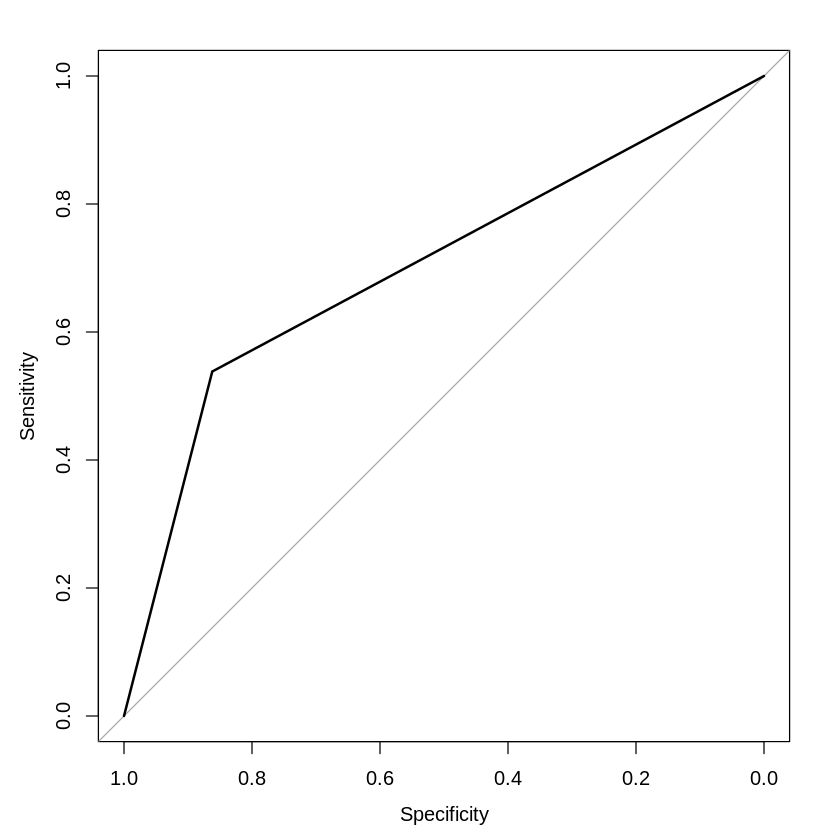

In [99]:
plot(roc.plot)

In [72]:
auc(roc.plot)

Area under the curve: 0.4537